In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
print("Device:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

PyTorch version: 2.5.1
Device: cpu


In [3]:
def load_and_preprocess_data(csv_path):
    """
    Load data from CSV and preprocess it for neural network training.

    Args:
        csv_path: Path to the CSV file

    Returns:
        Xs: numpy array of shape (n_samples, 20, 20) with pixel values 0-1
        Ys: numpy array of shape (n_samples,) with label indices
        char_to_idx: dictionary mapping unicode values to label indices
        idx_to_char: dictionary mapping label indices to unicode values
    """
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"Data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns

    # Extract pixel values (columns r0c0 to r19c19)
    pixel_columns = []
    for r in range(20):
        for c in range(20):
            pixel_columns.append(f'r{r}c{c}')

    # Check if all pixel columns exist
    missing_cols = [col for col in pixel_columns if col not in df.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols[:5]}...")

    # Extract pixel data and labels
    pixel_data = df[pixel_columns].values  # Shape: (n_samples, 400)
    labels = df['m_label'].values  # Unicode values

    # Normalize pixel values to 0-1 range
    pixel_data = pixel_data.astype(np.float32) / 255.0

    # Reshape to 20x20 images
    Xs = pixel_data.reshape(-1, 20, 20)

    # Create label mapping (unicode to index)
    unique_labels = sorted(np.unique(labels))
    char_to_idx = {char: idx for idx, char in enumerate(unique_labels)}
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}

    # Convert labels to indices
    Ys = np.array([char_to_idx[label] for label in labels])

    print(f"Number of samples: {len(Xs)}")
    print(f"Image shape: {Xs[0].shape}")
    print(f"Number of unique characters: {len(unique_labels)}")
    print(f"Characters: {[chr(int(char)) if char < 128 else f'U+{int(char):04X}' for char in unique_labels[:10]]}")

    return Xs, Ys, char_to_idx, idx_to_char

In [4]:
# Load the MONEY.csv data
Xs, Ys, char_to_idx, idx_to_char = load_and_preprocess_data("./data/MONEY.csv")

# Display some basic statistics
print(f"\nDataset Statistics:")
print(f"Total samples: {len(Xs)}")
print(f"Image dimensions: {Xs[0].shape}")
print(f"Number of classes: {len(char_to_idx)}")
print(f"Label distribution: {Counter(Ys)}")

Loading data from ./data/MONEY.csv...
Data shape: (7553, 412)
Columns: ['font', 'fontVariant', 'm_label', 'strength', 'italic', 'orientation', 'm_top', 'm_left', 'originalH', 'originalW']...
Number of samples: 7553
Image shape: (20, 20)
Number of unique characters: 35
Characters: ['*', '0', '1', '2', '3', '4', '5', '6', '7', '8']

Dataset Statistics:
Total samples: 7553
Image dimensions: (20, 20)
Number of classes: 35
Label distribution: Counter({np.int64(6): 739, np.int64(9): 686, np.int64(8): 640, np.int64(1): 602, np.int64(3): 578, np.int64(5): 539, np.int64(7): 520, np.int64(10): 509, np.int64(4): 508, np.int64(2): 463, np.int64(22): 211, np.int64(12): 180, np.int64(14): 158, np.int64(11): 158, np.int64(15): 126, np.int64(17): 109, np.int64(13): 109, np.int64(30): 91, np.int64(21): 76, np.int64(20): 76, np.int64(0): 66, np.int64(28): 59, np.int64(16): 48, np.int64(27): 48, np.int64(26): 46, np.int64(18): 37, np.int64(19): 30, np.int64(24): 22, np.int64(34): 22, np.int64(29): 20, np

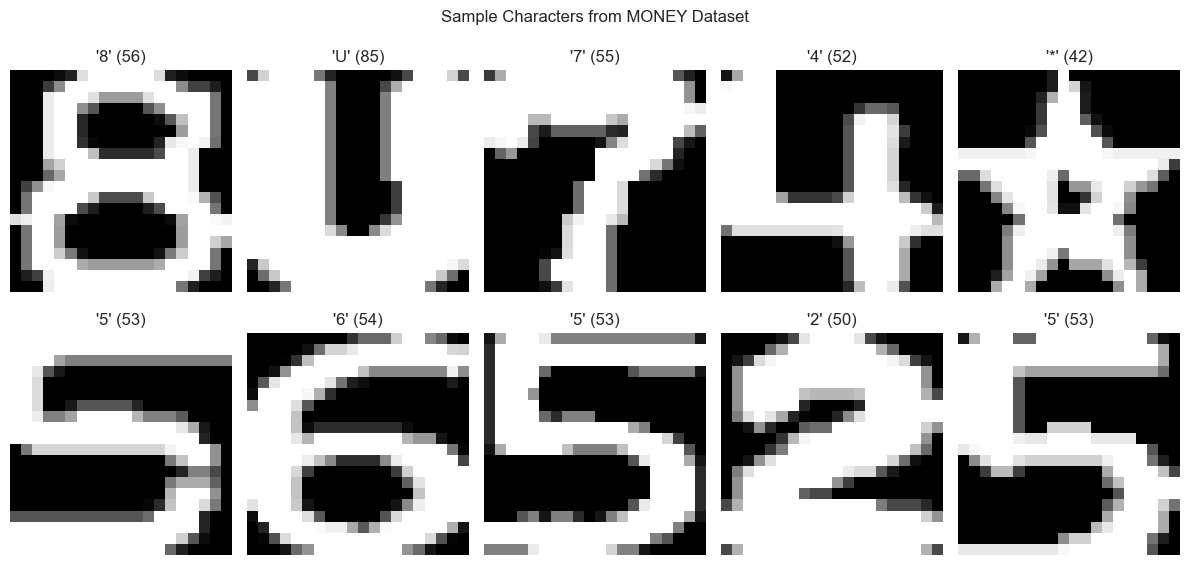

In [5]:
def visualize_sample_characters(Xs, Ys, idx_to_char, num_samples=10):
    """Visualize sample characters from the dataset"""
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()

    # Show random samples
    indices = np.random.choice(len(Xs), num_samples, replace=False)

    for i, idx in enumerate(indices):
        char_code = idx_to_char[Ys[idx]]
        char_display = chr(int(char_code)) if char_code < 128 else f'U+{int(char_code):04X}'

        axes[i].imshow(Xs[idx], cmap='gray')
        axes[i].set_title(f"'{char_display}' ({int(char_code)})")
        axes[i].axis('off')

    plt.suptitle('Sample Characters from MONEY Dataset')
    plt.tight_layout()
    plt.show()

# Visualize some sample characters
visualize_sample_characters(Xs, Ys, idx_to_char)

In [6]:
class CharacterCNN(nn.Module):
    """Basic CNN for character classification"""

    def __init__(self, num_classes):
        super(CharacterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 20x20 -> 10x10
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 10x10 -> 5x5

        # Calculate the size after convolutions
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ImprovedCharacterCNN(nn.Module):
    """Improved CNN with batch normalization and more layers"""

    def __init__(self, num_classes):
        super(ImprovedCharacterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

print("Model classes defined successfully!")

Model classes defined successfully!


In [7]:
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    """Train the model and return training history"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    print(f"Training on {device}")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss, train_correct = 0, 0
        train_total = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        val_total = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()

        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, test_loader, idx_to_char):
    """Evaluate model and return predictions for analysis"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()

    all_preds, all_labels, all_probs = [], [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return np.array(all_preds), np.array(all_labels), np.array(all_probs), accuracy

In [8]:
# Prepare data for PyTorch
X_reshaped = Xs.reshape(-1, 1, 20, 20)  # Add channel dimension for CNN
X_tensor = torch.FloatTensor(X_reshaped)
Y_tensor = torch.LongTensor(Ys)

# Split data into train/validation/test
X_train, X_test, Y_train, Y_test = train_test_split(
    X_tensor, Y_tensor, test_size=0.2, random_state=42, stratify=Ys
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

# Create data loaders
batch_size = 32
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of classes: {len(char_to_idx)}")

Training samples: 4833
Validation samples: 1209
Test samples: 1511
Number of classes: 35


In [9]:
print("="*50)
print("TRAINING BASIC CNN MODEL")
print("="*50)

num_classes = len(char_to_idx)
basic_model = CharacterCNN(num_classes)

# Train the basic model
basic_train_losses, basic_val_losses, basic_train_accs, basic_val_accs = train_model(
    basic_model, train_loader, val_loader, epochs=20
)

print("\nBasic CNN training completed!")


TRAINING BASIC CNN MODEL
Training on cpu
Epoch [5/20], Train Acc: 97.17%, Val Acc: 99.26%
Epoch [10/20], Train Acc: 98.34%, Val Acc: 99.59%
Epoch [15/20], Train Acc: 98.84%, Val Acc: 99.67%
Epoch [20/20], Train Acc: 99.11%, Val Acc: 99.67%

Basic CNN training completed!


In [10]:
print("Evaluating Basic CNN on Test Set:")
basic_preds, basic_labels, basic_probs, basic_accuracy = evaluate_model(
    basic_model, test_loader, idx_to_char
)

# Store results for comparison
results = {'Basic CNN': basic_accuracy}
print(f"\nBasic CNN Test Accuracy: {basic_accuracy:.2f}%")

Evaluating Basic CNN on Test Set:
Test Accuracy: 99.93%

Basic CNN Test Accuracy: 99.93%


In [11]:
print("="*50)
print("TRAINING IMPROVED CNN MODEL")
print("="*50)

improved_model = ImprovedCharacterCNN(num_classes)

# Train the improved model
improved_train_losses, improved_val_losses, improved_train_accs, improved_val_accs = train_model(
    improved_model, train_loader, val_loader, epochs=20
)

print("\nImproved CNN training completed!")

TRAINING IMPROVED CNN MODEL
Training on cpu
Epoch [5/20], Train Acc: 96.90%, Val Acc: 99.59%
Epoch [10/20], Train Acc: 98.24%, Val Acc: 99.75%
Epoch [15/20], Train Acc: 98.49%, Val Acc: 99.83%
Epoch [20/20], Train Acc: 98.82%, Val Acc: 99.83%

Improved CNN training completed!


In [12]:
print("Evaluating Improved CNN on Test Set:")
improved_preds, improved_labels, improved_probs, improved_accuracy = evaluate_model(
    improved_model, test_loader, idx_to_char
)

# Update results
results['Improved CNN'] = improved_accuracy
print(f"\nImproved CNN Test Accuracy: {improved_accuracy:.2f}%")
print(f"Improvement: {improved_accuracy - basic_accuracy:.2f} percentage points")

Evaluating Improved CNN on Test Set:
Test Accuracy: 99.93%

Improved CNN Test Accuracy: 99.93%
Improvement: 0.00 percentage points


In [13]:
def analyze_misclassifications(preds, labels, probs, idx_to_char, model_name, top_k=10):
    """Analyze misclassified examples"""
    misclassified = preds != labels
    misclassified_indices = np.where(misclassified)[0]

    print(f"\n{model_name} - Misclassification Analysis:")
    print(f"Total misclassified: {len(misclassified_indices)} out of {len(labels)}")

    # Show examples of misclassifications
    print(f"\nTop {top_k} misclassifications:")
    for i, idx in enumerate(misclassified_indices[:top_k]):
        true_char = chr(int(idx_to_char[labels[idx]])) if idx_to_char[labels[idx]] < 128 else f"U+{int(idx_to_char[labels[idx]]):04X}"
        pred_char = chr(int(idx_to_char[preds[idx]])) if idx_to_char[preds[idx]] < 128 else f"U+{int(idx_to_char[preds[idx]]):04X}"
        confidence = probs[idx][preds[idx]]
        print(f"  {i+1}. True: '{true_char}', Predicted: '{pred_char}', Confidence: {confidence:.3f}")

    # Find uncertain predictions (low confidence)
    max_probs = np.max(probs, axis=1)
    uncertain_indices = np.where(max_probs < 0.6)[0]  # Low confidence threshold

    print(f"\nUncertain predictions (confidence < 0.6): {len(uncertain_indices)}")
    for i, idx in enumerate(uncertain_indices[:5]):
        true_char = chr(int(idx_to_char[labels[idx]])) if idx_to_char[labels[idx]] < 128 else f"U+{int(idx_to_char[labels[idx]]):04X}"
        pred_char = chr(int(idx_to_char[preds[idx]])) if idx_to_char[preds[idx]] < 128 else f"U+{int(idx_to_char[preds[idx]]):04X}"
        confidence = max_probs[idx]
        print(f"  {i+1}. True: '{true_char}', Predicted: '{pred_char}', Confidence: {confidence:.3f}")

# Analyze both models
analyze_misclassifications(basic_preds, basic_labels, basic_probs, idx_to_char, "Basic CNN")
analyze_misclassifications(improved_preds, improved_labels, improved_probs, idx_to_char, "Improved CNN")


Basic CNN - Misclassification Analysis:
Total misclassified: 1 out of 1511

Top 10 misclassifications:
  1. True: 'F', Predicted: 'G', Confidence: 0.635

Uncertain predictions (confidence < 0.6): 1
  1. True: 'W', Predicted: 'W', Confidence: 0.519

Improved CNN - Misclassification Analysis:
Total misclassified: 1 out of 1511

Top 10 misclassifications:
  1. True: 'W', Predicted: 'A', Confidence: 0.284

Uncertain predictions (confidence < 0.6): 3
  1. True: 'W', Predicted: 'A', Confidence: 0.284
  2. True: 'B', Predicted: 'B', Confidence: 0.597
  3. True: 'B', Predicted: 'B', Confidence: 0.558


In [14]:
class DenoisingAutoencoder(nn.Module):
    """Convolutional autoencoder for denoising"""

    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 20x20 -> 10x10
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 10x10 -> 5x5
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 5x5 -> 10x10
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 10x10 -> 20x20
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def add_noise(images, noise_factor=0.3):
    """Add Gaussian noise to images"""
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)

print("Autoencoder class defined successfully!")

Autoencoder class defined successfully!


In [15]:
def train_autoencoder(model, train_loader, val_loader, epochs=15):
    """Train the denoising autoencoder"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    print(f"Training autoencoder on {device}")

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0

        for batch_x, _ in train_loader:  # We don't need labels for autoencoder
            batch_x = batch_x.to(device)
            noisy_batch = add_noise(batch_x).to(device)

            optimizer.zero_grad()
            outputs = model(noisy_batch)
            loss = criterion(outputs, batch_x)  # Compare with clean images
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch_x, _ in val_loader:
                batch_x = batch_x.to(device)
                noisy_batch = add_noise(batch_x).to(device)
                outputs = model(noisy_batch)
                loss = criterion(outputs, batch_x)
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    return train_losses, val_losses

# Train the autoencoder
print("="*50)
print("TRAINING DENOISING AUTOENCODER")
print("="*50)

autoencoder = DenoisingAutoencoder()
ae_train_losses, ae_val_losses = train_autoencoder(autoencoder, train_loader, val_loader)

print("\nAutoencoder training completed!")

TRAINING DENOISING AUTOENCODER
Training autoencoder on cpu
Epoch [5/15], Train Loss: 0.0153, Val Loss: 0.0167
Epoch [10/15], Train Loss: 0.0131, Val Loss: 0.0137
Epoch [15/15], Train Loss: 0.0120, Val Loss: 0.0146

Autoencoder training completed!


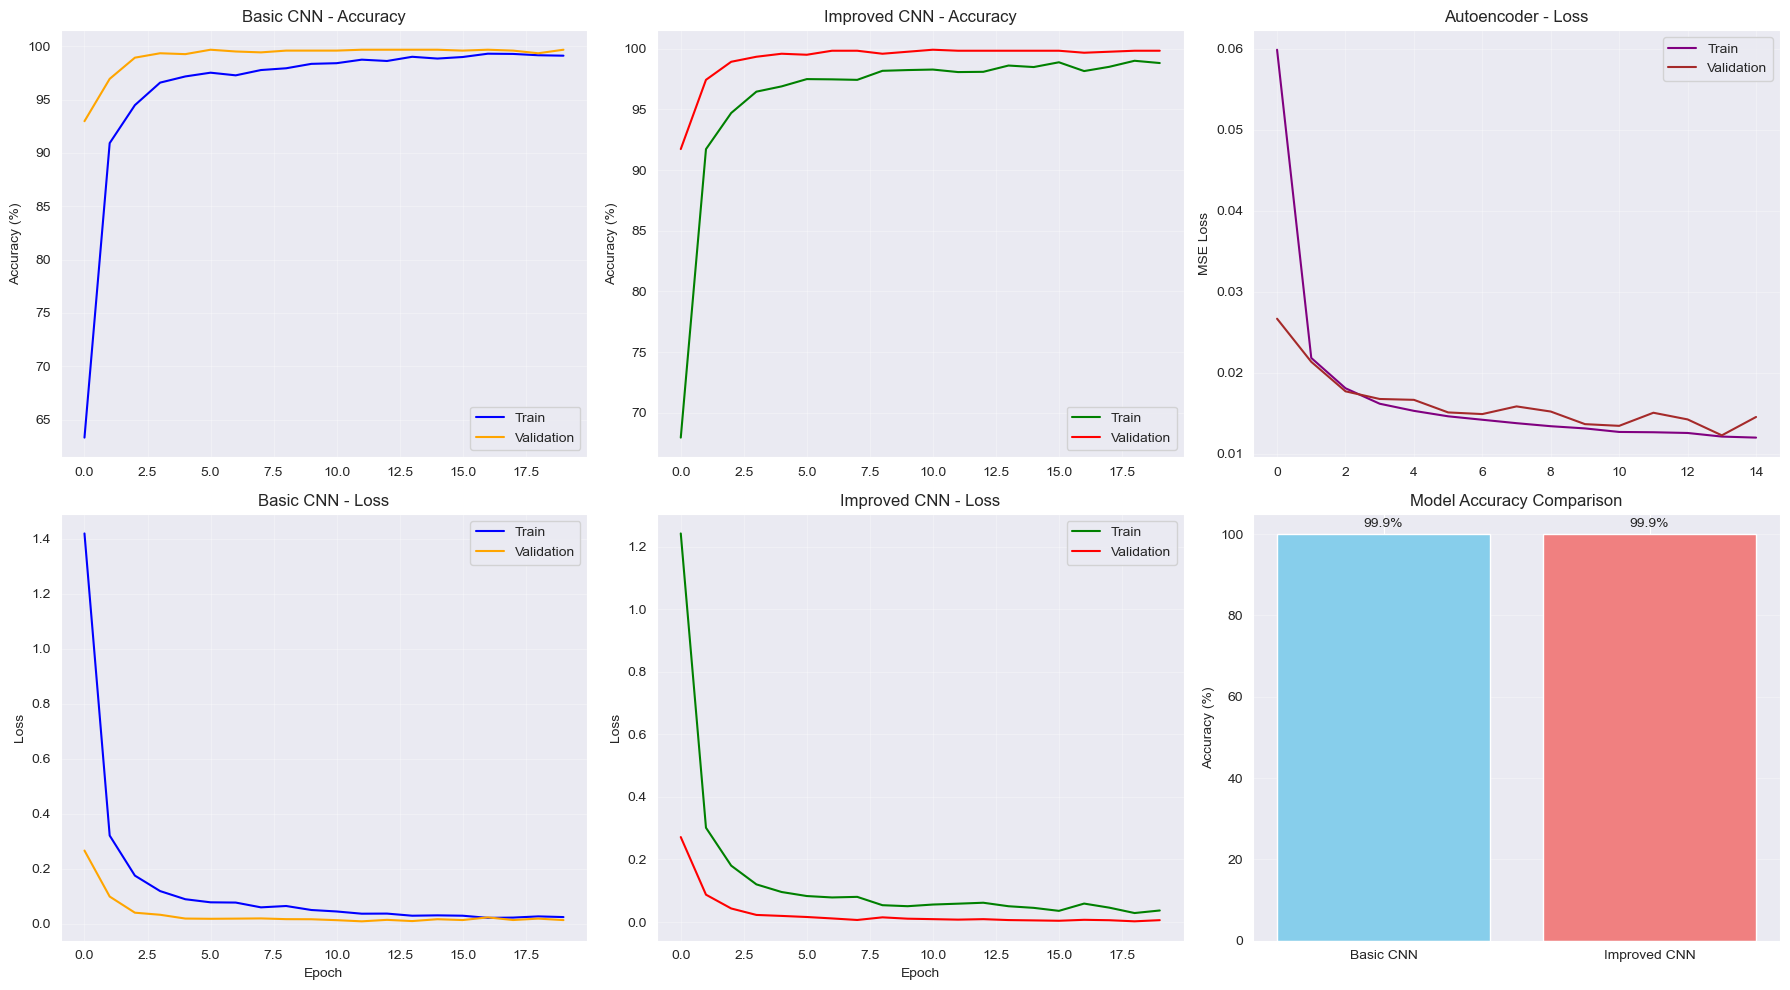

In [16]:
def plot_training_history():
    """Plot training history for all models"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Basic CNN
    axes[0, 0].plot(basic_train_accs, label='Train', color='blue')
    axes[0, 0].plot(basic_val_accs, label='Validation', color='orange')
    axes[0, 0].set_title('Basic CNN - Accuracy')
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[1, 0].plot(basic_train_losses, label='Train', color='blue')
    axes[1, 0].plot(basic_val_losses, label='Validation', color='orange')
    axes[1, 0].set_title('Basic CNN - Loss')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Improved CNN
    axes[0, 1].plot(improved_train_accs, label='Train', color='green')
    axes[0, 1].plot(improved_val_accs, label='Validation', color='red')
    axes[0, 1].set_title('Improved CNN - Accuracy')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 1].plot(improved_train_losses, label='Train', color='green')
    axes[1, 1].plot(improved_val_losses, label='Validation', color='red')
    axes[1, 1].set_title('Improved CNN - Loss')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Autoencoder
    axes[0, 2].plot(ae_train_losses, label='Train', color='purple')
    axes[0, 2].plot(ae_val_losses, label='Validation', color='brown')
    axes[0, 2].set_title('Autoencoder - Loss')
    axes[0, 2].set_ylabel('MSE Loss')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Accuracy comparison
    models = list(results.keys())
    accuracies = list(results.values())
    bars = axes[1, 2].bar(models, accuracies, color=['skyblue', 'lightcoral'])
    axes[1, 2].set_title('Model Accuracy Comparison')
    axes[1, 2].set_ylabel('Accuracy (%)')
    axes[1, 2].grid(True, axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        axes[1, 2].annotate(f'{acc:.1f}%',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history()

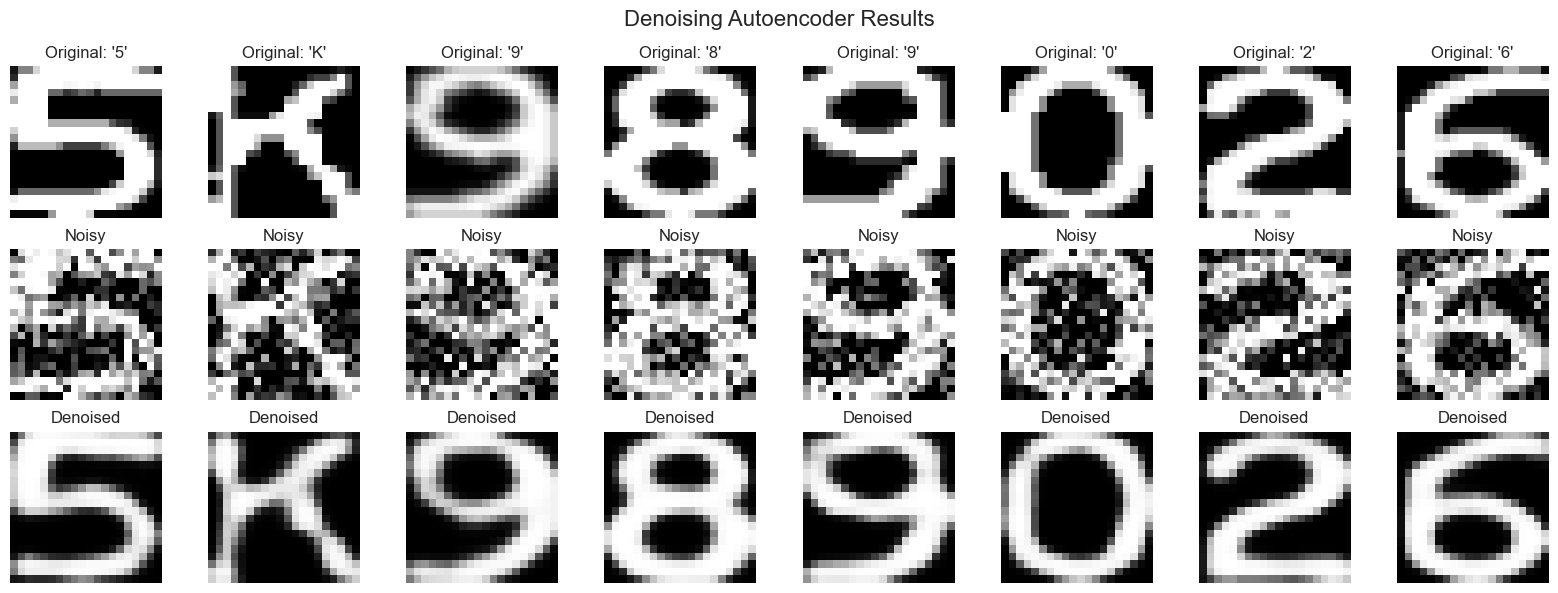

In [17]:
def visualize_denoising_results(autoencoder, test_loader, num_examples=8):
    """Visualize denoising results"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    autoencoder.eval()

    # Get a batch of test data
    data_iter = iter(test_loader)
    test_batch, test_labels = next(data_iter)
    test_batch = test_batch[:num_examples]
    test_labels = test_labels[:num_examples]

    # Add noise
    noisy_batch = add_noise(test_batch, noise_factor=0.4)

    # Denoise
    with torch.no_grad():
        test_batch = test_batch.to(device)
        noisy_batch = noisy_batch.to(device)
        denoised_batch = autoencoder(noisy_batch)

    # Move to CPU for visualization
    test_batch = test_batch.cpu()
    noisy_batch = noisy_batch.cpu()
    denoised_batch = denoised_batch.cpu()

    fig, axes = plt.subplots(3, num_examples, figsize=(2*num_examples, 6))

    for i in range(num_examples):
        # Get character for title
        char_code = idx_to_char[test_labels[i].item()]
        char_display = chr(int(char_code)) if char_code < 128 else f'U+{int(char_code):04X}'

        # Original
        axes[0, i].imshow(test_batch[i][0], cmap='gray')
        axes[0, i].set_title(f"Original: '{char_display}'")
        axes[0, i].axis('off')

        # Noisy
        axes[1, i].imshow(noisy_batch[i][0], cmap='gray')
        axes[1, i].set_title('Noisy')
        axes[1, i].axis('off')

        # Denoised
        axes[2, i].imshow(denoised_batch[i][0], cmap='gray')
        axes[2, i].set_title('Denoised')
        axes[2, i].axis('off')

    plt.suptitle('Denoising Autoencoder Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize denoising results
visualize_denoising_results(autoencoder, test_loader)